In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime
from scipy.optimize import minimize

## Group Assignment
### Team Number: 11
### Team Member Names: Akram, Annie, Jester
### Team Strategy Chosen: Market Beat

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.

Utilized ChatGPT for detecting syntax errors and to assist in graph formatting.

Estimated Runtime: 
1. Best case: 3 mins
2. Worst case: 4 mins

---
## 📝 **General Strategy for the Project**:

#### Initialization
0) Define and initialize necessary global variables

#### Part #1: Data Filtering and Cleaning
1) Filter out all valid US and CAD Stocks from the provided CSV file. 
2) Download and store closing price (US stocks are converted to CAD), options and volume data in a dictionary using yfinance.
3) Filter out tickers within date range based on given minimum monthly average volume.

#### Part #2: Portfolio Construction
4) Rank stocks based on Standard Deviation of percentage change in returns in descending order.
5) Rank stocks based on PCR values using options data in descending order.
6) Score the stocks based on the two ranks, and create a new ranking based on the scoring.
7) We select stocks based on the ranking and calculate weights that would maximize the portfolio sharpe ratio while beta is within pre-defined constraints.
8) Run sharpe ratio optimization function on portfolio from size 12(min) to 24(max), so that the final portfolio (with weightings) is picked based on highest output sharpe ratio given beta constraint.

#### Part #3: Evaluation and Proof
9) Now that we have the final best portfolio, we track its value over previous dates and compare it to the market index of S&P500 and TSX60 by splitting the investment equally between the two indices.
10) Sharpe ratio between our portfolio with varied weight versus when it is equally weighted.
11) Graphically compare sharpe ratios amongst our final portfolio and the portfolios of varying 12-24 stocks.

#### Part #4: Final Output
12) Creating the final portfolio dataframe and CSV.

<br>

--- 

## 🌐 0. Initializing Variables

In [2]:
# function to read in tickers from csv file
def get_tickers():
    tickers = pd.read_csv('Tickers.csv')
    ticker_lst = [tickers.columns[0]] + (list(tickers[tickers.columns[0]]))
    return ticker_lst

In [3]:
# Important Constants: 
amount = 1_000_000 # Initial investment amount of $1,000,000
group = 11

# Define constants
min_avg_volume = 100000
min_trading_days = 18
min_stocks, max_stocks = 12, 24
start_date, end_date = "2022-09-30", "2024-09-30"

# Reading in CSV file: 
ticker_lst = get_tickers()

# Initializing variable to store the tickers we will use in our portfolio
columns = ['Ticker', 'Price', 'Currency', 'Shares', 'Value', 'Weight']
Portfolio_Final = pd.DataFrame(columns=columns)
exchange_rate = yf.Ticker('CAD=X').fast_info['last_price']
print(f'The current exchange rate for the latest available day:\nUSD -> CAD: ${np.round(exchange_rate, 4)}')

The current exchange rate for the latest available day:
USD -> CAD: $1.398


---
## 🧼 1. Data Filtering and Cleaning

#### We must filter the tickers csv as follows:
- Must be listed on yfinance
- The currency is listed as USD or CAD 
- 100,000+ average monthly volume trades (only considering months with more than 18 trading days)
- Sufficient data

In [4]:
# Filtering valid stocks by inputting a list of strings for each ticker. 
def filter_stocks(ticker_lst):
    # Function to drop short trading months (less than 18 trading days per month)
    def drop_short_trading_months(df):
        """
        Drops months with less than 18 trading days from a yfinance history DataFrame.
        Parameters:
            df (pd.DataFrame): A yfinance DataFrame with a DatetimeIndex and stock data.
        Returns:
            pd.DataFrame: Filtered DataFrame with only months having >= 18 trading days.
        """
        # Ensure the index is a DatetimeIndex
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("The DataFrame index must be a DatetimeIndex.")
        # Remove timezone information to avoid warnings
        df = df.copy()  # Avoid modifying the original DataFrame
        df.index = df.index.tz_localize(None)
        # Group by year and month
        df['YearMonth'] = df.index.to_period('M')  # Creates a 'YearMonth' period
        # Count trading days for each month
        trading_days_per_month = df.groupby('YearMonth').size()
        # Get valid months with at least 18 trading days
        valid_months = trading_days_per_month[trading_days_per_month >= 18].index
        # Filter DataFrame to include only rows in valid months
        filtered_df = df[df['YearMonth'].isin(valid_months)].drop(columns=['YearMonth'])
        return filtered_df
    
    valid_tickers, invalid_tickers, usdstocks = {}, [], []
    # Loop through all tickers to check if they are valid
    for ticker in ticker_lst:
        stock = yf.Ticker(ticker)
        try:
            info = stock.fast_info # Get basic stock info

            hist = stock.history(start=start_date, end=end_date) # Get stock history
            pd.to_datetime(hist.index, format='%Y-%m-%d')
            
            avg_volume = hist.loc[((hist.index >= start_date) & (hist.index <= end_date))]['Volume'].mean() # Calculate average volume in specified date range.
            currency = info.get("currency")
            if ((hist.empty is not None) and # filter for stocks delisted on yfinance
                ( currency == "USD" or currency == "CAD") and # filter for stocks that are not USD
                (avg_volume >= min_avg_volume)): # Filter by volume greater than 100,000
                if currency == "CAD":
                    hist = drop_short_trading_months(hist)
                    hist.index = hist.index.strftime('%Y-%m-%d')
                    valid_tickers[ticker] = hist['Close'] # Store the close prices of the stock as a Series
                elif currency == "USD":
                    hist = drop_short_trading_months(hist)
                    hist.index = hist.index.strftime('%Y-%m-%d')
                    usdstocks.append(ticker)
                    valid_tickers[ticker] = hist['Close'] * exchange_rate # Convert USD to CAD
            else:
                invalid_tickers.append(ticker)
        except:
            invalid_tickers.append(ticker)
    return [valid_tickers, invalid_tickers, usdstocks]
    # valid_tickers is a dictionary of Series where the key is the name of the ticker. 
    # invalid_tickers is a list of ticker strings which were removed in the filtering process. 
    # usdstocks is a list of ticker strings which were converted from USD to CAD.

This code block is designed to load and organize historical stock data into a structured DataFrame for financial analysis. It filters a list of stock tickers to retain only those meeting specific criteria (e.g., sufficient trading volume and valid data), retrieves their historical price data, and stores the data in a DataFrame for further processing later on.

In [5]:
# Loading data into variables
stock_filter = filter_stocks(ticker_lst)
ticker_data = stock_filter[0]
ticker_lst = list(ticker_data.keys()) # Reassign original ticker list
data = pd.DataFrame()
for ticker in ticker_data:
    data[ticker] = ticker_data[ticker]

data.head()

$ASDFAASDF.TO: possibly delisted; no timezone found
$ASDFAASDF.TO: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$INVALIDTIC: possibly delisted; no timezone found
$INVALIDTIC: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$HDFC.NS: possibly delisted; no timezone found
$HDFC.NS: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$CELG: possibly delisted; no timezone found
$CELG: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$AW.TO: possibly delisted; no price data found  (1d 2022-09-30 -> 2024-09-30) (Yahoo error = "Data doesn't exist for startDate = 1664510400, endDate = 1727668800")


,AAPL,ABBV,LOW,HOOD,AMZN,AXP,BAC,BK,SQ,VZ,...,OXY,DUOL,PEP,T.TO,SLB,SO,SPG,SHOP.TO,RY.TO,TD.TO
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-03,196.746273,177.502099,259.179315,14.119801,162.000236,189.887868,41.093765,51.519780,77.980438,47.021264,...,87.307640,135.606000,218.096682,25.033075,51.387443,89.378791,113.234235,37.799999,114.575363,77.623260
2022-10-04,201.787550,182.211710,263.857141,15.126360,169.283815,197.265296,42.798847,53.741139,87.249180,47.801762,...,90.183351,142.218545,220.551523,25.316832,52.487652,90.609304,119.320354,42.610001,117.543640,79.079193
2022-10-05,202.201920,183.931265,266.008986,15.042480,169.088096,195.787067,42.190830,53.728154,86.885702,47.309451,...,92.323111,142.637938,219.086563,25.104010,55.774837,88.097006,119.195883,41.959999,117.041313,78.620850
2022-10-06,200.862177,180.030130,267.278653,15.615660,168.179404,193.088340,41.582815,52.844804,86.578141,46.202027,...,96.084726,145.797421,214.863167,24.421211,57.009212,84.251675,117.839256,41.320000,113.762505,75.751686
2022-10-07,193.486797,178.066688,263.576543,15.098400,160.154877,188.504523,40.644361,51.285952,80.259180,44.993245,...,95.130705,137.703000,213.292615,24.376873,57.143378,82.187989,115.175812,37.349998,110.520241,74.671196


---
## 🏗️ 2. Portfolio Construction

To begin, we calculate the standard deviation (std) of the percentage change in returns of stocks to determine volatility. Each ticker will also be assigned a score based on its std value compared to the highest standard deviation and sorted in descending order. This is because the more volatile the stock, the better it is for beating the market, as there is a greater possibility to generate higher returns than the market.

In [6]:
def calculate_std(data):
    """
        Calculates the standard deviation for all the stocks in data and scores each stock.
        Parameters:
            data (pd.DataFrame): A yfinance DataFrame with a DatetimeIndex and stock data.
        Returns:
            pd.DataFrame: Scored DataFrame with each stock and its score based off of standard deviation ranked.
    """
    data.index = pd.to_datetime(data.index)
    
    # Calculate daily percentage returns
    returns = data.pct_change(fill_method=None).dropna()

    # Calculate standard deviation of returns
    std = pd.DataFrame(returns.std(), columns=['Standard Deviation'])

    # Sort by standard deviation
    std_sorted = std.sort_values(by='Standard Deviation', ascending=False)

    # Add Rank column
    std_sorted['Rank'] = range(len(std_sorted))

    # Add Score column
    highest_std_value = std_sorted['Standard Deviation'].iloc[0]
    std_sorted['Score'] = (std_sorted['Standard Deviation'] / highest_std_value) * 100

    return std_sorted

We also calculated the average percentage change in returns of stocks (ret) to determine whether or not they have increased in value over the past two years, and if so, how much, as we would like stocks that have a positive return over the last two years. They are scored and sorted in a similar logic to std.

In [7]:
def calculate_return(data):
    """
        Calculates the percentage returns for all the stocks in data and scores each stock.
        Parameters:
            data (pd.DataFrame): A yfinance DataFrame with a DatetimeIndex and stock data.
        Returns:
            pd.DataFrame: Scored DataFrame with each stock and its score based off of percentage returns ranked.
    """

    data.index = pd.to_datetime(data.index)
    
    # Calculate daily percentage returns
    returns = data.pct_change(fill_method=None).dropna()

    # Calculate standard deviation of returns
    ret = pd.DataFrame(returns.mean(), columns=['Return'])

    # Sort by standard deviation
    ret_sorted = ret.sort_values(by='Return', ascending=False)

    # Add Rank column
    ret_sorted['Rank'] = range(len(ret_sorted))

    # Add Score column
    highest_ret_value = ret_sorted['Return'].iloc[0]
    ret_sorted['Score'] = (ret_sorted['Return'] / highest_ret_value) * 100

    return ret_sorted

This code block is designed to analyze options trading data for a list of stock tickers and calculate their Put-Call Ratio (PCR), a key indicator of market sentiment. By aggregating the total volume of put and call options for each stock, it computes the PCR to identify whether the market sentiment is bullish or bearish for that stock. (Ideally, it aggregates the opinions of investors on the stock). The PCR results are then stored in a DataFrame for future comparison and the ranking of stocks based on their options activity. Note: To facilitate scoring, they are calculated as CALL to PUT instead, however the results will still be the same regardless.

In [8]:
# Function to get the total volume for a call or put of a given stock.
# ticker: yfinance Ticker class
# put: Boolean for if you want to calculate put volume. Else, put False for call volume. 
def get_options_vol(ticker, put):
    """
        Retrieves the volume of call and put options for a stock.
        Parameters:
            ticker (str): The stock's ticker.
            put (bool): True if we want to return put options and false if we want call options.
        Returns:
            int: The options volume data.
    """
    exps = ticker.options # Expiration dates of available options
    optdata = pd.DataFrame() # Data storage
    for exp in exps:
        chain = pd.DataFrame()
        if put: chain = ticker.option_chain(exp).puts['volume'] # Gets the desired columns
        else: chain = ticker.option_chain(exp).calls['volume'] # If put options are desired then use this data.
        optdata = pd.concat([optdata, chain]) # Add the calls/puts to the main dataframe. 
    return optdata.sum()['volume'] # output total volume of put/call options

# Function to calculate the PCR for each stock. 
def PCR_calc(tickers):
    """
        Calculates the put to call ratio (PCR) for all stocks in tickers.
        Parameters:
            tickers (list): A yfinance DataFrame with a DatetimeIndex and stock data.
        Returns:
            pd.DataFrame: DataFrame with each stock and its PCR values.
    """
    pcrdata = pd.DataFrame(columns=['Ticker', 'Put Volume', 'Call Volume', 'PCR'])
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        try: 
            # Get the volume for Put and Call options:
            call_options = get_options_vol(stock, False)
            put_options = get_options_vol(stock, True)
            # Calculate PCR Ratio:
            pcr = call_options / put_options # Order reversed from the formula for sake of ranking
            #print(f"Ticker: {ticker}, PCR: {pcr}")  # Debugging
            pcrdata.loc[len(pcrdata)] = [ticker, put_options, call_options, pcr]
        except Exception as e:
            print(f"Options Data Not Found {ticker}: {e} not found")  # Debugging (output error)
            pass
    return pcrdata

We call the calculation functions and store the results as variables for calculations later on.

In [9]:
std = calculate_std(data)
std.head()

,Standard Deviation,Rank,Score
SHOP,0.037989,0,100.000000
DUOL,0.037620,1,99.029693
SHOP.TO,0.036675,2,96.541665
HOOD,0.034593,3,91.060558
SQ,0.034347,4,90.413647


In [10]:
ret = calculate_return(data)
ret.head()

,Return,Rank,Score
SHOP,0.003184,0,100.000000
DUOL,0.003140,1,98.605041
SHOP.TO,0.003137,2,98.506698
ORCL,0.002519,3,79.112914
HOOD,0.002313,4,72.654082


In [11]:
# Load the PCR values for each of the valid stocks into a variable
options_data = PCR_calc(ticker_lst)
options_data = options_data.sort_values(by='PCR', ascending=False)
options_data['Rank'] = [i for i in range(len(options_data))]
highest_pcr = options_data['PCR'].iloc[0]
options_data['Score'] = (options_data['PCR'] / highest_pcr) * 100
options_data.set_index('Ticker', inplace=True)


# Display the table of rankings based off PCR. 
# The rankings are based off the stocks with the greatest sentiment for if they will go up or not
# The tickers at the top of the list have a high call rate (meaning the price will go up)
pcr = options_data
pcr.head()

Options Data Not Found T.TO: 'volume' not found
Options Data Not Found SHOP.TO: 'volume' not found
Options Data Not Found RY.TO: 'volume' not found
Options Data Not Found TD.TO: 'volume' not found


,Put Volume,Call Volume,PCR,Rank,Score
Ticker,,,,,
SQ,14894.0,92553.0,6.214113,0,100.000000
IBM,8906.0,29672.0,3.331687,1,53.614836
PEP,9537.0,31670.0,3.320751,2,53.438853
HOOD,34536.0,98338.0,2.847406,3,45.821593
SHOP,13510.0,38028.0,2.814804,4,45.296953


This function, calculate_scoreboard, is designed to merge three previously calculated DataFrames containing std, ret and pcr scores for stocks and calculate a combined "Average Score" for each stock. The function is intended to rank stocks based on multiple scoring metrics (Score_std, Score_pcr, and Score_ret), prioritizing those with positive return scores, and ensuring that stocks with negative return scores are included but ranked lower (they are not omitted such that if there are less than 12 stocks with positive returns, the ‘best’ of the negative return stocks are picked first). This helps in identifying and filtering stocks with the most favourable overall metrics for our portfolio construction.

In [12]:
def calculate_scoreboard(std, pcr, ret):
    """
    Merges three DataFrames (std, pcr, ret) on their index (assumed to be ticker names),
    calculates the average of their 'Score' columns based on the following rules:
      - If 'Score_pcr' is NaN, calculate the average using 'Score_std' and 'Score_ret'.
      - Otherwise, calculate the average using 'Score_std', 'Score_pcr', and 'Score_ret'.
    Creates two DataFrames: one with positive 'Score_ret' and one with negative 'Score_ret',
    and appends the negative DataFrame to the positive one after sorting.
    """
    # Merge std and pcr DataFrames
    merged = std[['Score']].merge(
        pcr[['Score']], left_index=True, right_index=True, suffixes=('_std', '_pcr'), how='outer'
    )
    
    # Merge the resulting DataFrame with ret
    merged = merged.merge(
        ret[['Score']].rename(columns={'Score': 'Score_ret'}),  # Rename the Score column in ret
        left_index=True,
        right_index=True,
        how='outer'
    )

    # Calculate the average score based on the rules
    def calculate_average(row):
        if pd.isna(row['Score_pcr']):
            return row[['Score_std', 'Score_ret']].mean()  # Average of std and ret if pcr is NaN
        else:
            return row[['Score_std', 'Score_pcr', 'Score_ret']].mean()  # Average of all three otherwise

    merged['Average Score'] = merged.apply(calculate_average, axis=1)

    # Split into positive and negative Score_ret DataFrames
    positive_df = merged[merged['Score_ret'] > 0]
    negative_df = merged[merged['Score_ret'] <= 0]

    # Sort both DataFrames by 'Average Score' in descending order
    positive_sorted = positive_df.sort_values(by='Average Score', ascending=False)
    negative_sorted = negative_df.sort_values(by='Average Score', ascending=False)

    # Append the negative DataFrame to the positive one (keep it at the bottom as we don't want any negative average return stocks)
    final_df = pd.concat([positive_sorted, negative_sorted])

    return final_df



scores = calculate_scoreboard(std, pcr, ret)
scores

,Score_std,Score_pcr,Score_ret,Average Score
SHOP.TO,96.541665,NaN,98.506698,97.524182
SHOP,100.000000,45.296953,100.000000,81.765651
SQ,90.413647,100.000000,31.612388,74.008678
HOOD,91.060558,45.821593,72.654082,69.845411
DUOL,99.029693,11.131586,98.605041,69.588773
ORCL,52.159009,31.792767,79.112914,54.354896
AMZN,56.688615,40.057875,43.487044,46.744511
GOOG,52.075979,42.155932,42.206154,45.479355
IBM,33.407830,53.614836,44.281148,43.767938
AXP,43.195357,19.803795,48.752638,37.250597


In [13]:
# Load market data into a dataframe
s_p500 = yf.Ticker('^GSPC').history(start=start_date, end=end_date)['Close']
tsx60 = yf.Ticker('^GSPTSE').history(start=start_date, end=end_date)['Close']

SPreturns = s_p500.pct_change(fill_method=None).dropna()
TSX60Returns = tsx60.pct_change(fill_method=None).dropna()

avg_return = (SPreturns + TSX60Returns)/2

market_indices = pd.DataFrame({'S&P 500 PCT Returns': SPreturns, 
                               'TSX 60 PCT Returns': TSX60Returns, 
                               'Average Market Return': avg_return})
market_indices.index = market_indices.index.strftime('%Y-%m-%d')
market_indices.index = pd.to_datetime(market_indices.index)

market_indices.head()

,S&P 500 PCT Returns,TSX 60 PCT Returns,Average Market Return
Date,,,
2022-10-03,0.025884,0.023693,0.024788
2022-10-04,0.030584,0.025941,0.028262
2022-10-05,-0.002018,-0.007016,-0.004517
2022-10-06,-0.010245,-0.013314,-0.011780
2022-10-07,-0.028004,-0.020860,-0.024432


In [14]:
market_variance = market_indices['Average Market Return'].var()
print(f'Market Variance: {market_variance}')

Market Variance: 6.424001518121877e-05


In [15]:
def get_beta(weights, tickers):
    """
        Calculates the beta of a portfolio given its weights.
        Parameters:
            tickers (list): A yfinance DataFrame with a DatetimeIndex and stock data.
        Returns:
            pd.DataFrame: Scored DataFrame with each stock and its score based off of standard deviation ranked.
    """
    # creating prices dataframe
    prices = pd.DataFrame()
    for ticker in data.columns.tolist():
        if ticker in tickers:
            prices[ticker] = data[ticker]
    # initializing
    betas = []
    portfolio_beta = 0
    # calculate individual stock betas
    for ticker in tickers:
        compare = pd.DataFrame()
        compare['stock'] = prices[ticker].pct_change(fill_method=None).dropna()
        compare['market'] = market_indices['Average Market Return']
        beta = (compare.cov()/compare['market'].var()).iat[0,1]
        betas.append(beta)
    # calculate portfolio beta with weighted stock betas
    for i in range(len(weights)):
        portfolio_beta += betas[i] * weights[i]
    return portfolio_beta 

The function optimal_sharpe is designed to optimize the allocation of investment weights across a portfolio of stocks, aiming to achieve the highest possible Sharpe Ratio with given constraints. The Sharpe Ratio is a key financial metric that evaluates the risk-adjusted return of an investment portfolio, helping us to identify the best balance between risk and reward as we are looking to beat the market in the long run, and not necessarily on a seasonal basis or on the merit of pure luck. 

The function incorporates realistic constraints, such as trading fees, weight limits for each stock and a required beta constraint. It enforces the requirement that the sum of all stock weights equals one, ensuring full allocation of the investment capital, and to do this we allow fractional shares. Additionally, it sets bounds for each stock’s weight, allowing for a minimum weight to ensure diversification and a maximum weight to prevent excessive exposure to a single stock. The portfolio’s beta range must also be greater than 1 to ensure higher volatility than the market (i.e. arithmetic average percentage change in returns of S&P 500 and TSX). This implies that the inherent risk/return will be greater than the market by a certain margin. 

Specifically, to optimize the weightings of each stock to maximize the Sharpe ratio, the Sequential Least Squares Programming (SLSQP) optimization method from the scipy.optimize.minimize function is used from the SciPy Python library. The algorithm iteratively refines the weight allocation over a large number of efficient runs. It starts with an initial guess of equal weights and algorithmically adjusts them to minimize the negative Sharpe Ratio (i.e. which maximizes positive Sharpe Ratio). The result is a set of optimized weights that dictate the ideal allocation for each stock in the portfolio. Additionally, we output a negative Sharpe Ratio, which after taking the absolute value of, we are left with the true Sharpe Ratio for a given set of assets. 

In [16]:
# sharpe ratio optimization
avg_trading_days_py = 252 # Constant for average trading days per year (used for annualization)
def optimal_sharpe(tickers, risk_free_rate, investment):
    """
        Calculates the weights that will optimize the sharpe ratio and keep beta greater than 1 for a set of tickers.
        Parameters:
            tickers (list): A yfinance DataFrame with a DatetimeIndex and stock data.
            risk_free_rate (float): The risk free rate of the market.
            investment (float): The total amount available to buy stocks.
        Returns:
            pd.DataFrame: Scored DataFrame with each stock and its score based off of standard deviation ranked.
    """
    # creating prices dataframe
    prices = pd.DataFrame()

    for ticker in data.columns.tolist():
        if ticker in tickers:
            prices[ticker] = data[ticker]

    def neg_sharpe(weights):

        # determining number of shares of each stock that can be bought
        shares = []
        for i in range(len(tickers)):
            allocation = investment * weights[i]  # investment allocated to this stock
            price_per_share = prices.iloc[0][tickers[i].upper()]
            
            # clculate fees
            flat_fee = 3.95
            per_share_fee = allocation/price_per_share/(1000+1/price_per_share) 
            
            # choose the smaller of the two fees
            trading_fee = min(flat_fee, per_share_fee)
            
            # calculate the number of shares after deducting the fee
            effective_investment = allocation - trading_fee
            shares.append(effective_investment / price_per_share)
        
        # forming the portfolio
        portfolio = prices*shares
        portfolio['total'] = portfolio.sum(axis=1)
        portfolio['daily return'] = portfolio['total'].pct_change(1)

        # calculating sharpe ratio
        er = portfolio['daily return'].mean()
        std = portfolio['daily return'].std()
        sharpe_ratio = (er-risk_free_rate)/std
        
        sharpe_ratio = sharpe_ratio*(avg_trading_days_py**0.5) # annualizing sharpe ratio by trading days

        return -sharpe_ratio #make sharpe ratio negative for minimize function

    # constraints
    def check_sum(weights): 
        return np.sum(weights)-1 #returns 0 if weights sum up to 1

    def check_beta(weights): return get_beta(weights, tickers) - 1
    
    constraints = [
        {'type': 'eq', 'fun': check_sum},
        {'type': 'ineq', 'fun': check_beta}
    ]

    min_weight = 1/(2*len(tickers))
    max_weight = 0.4

    bounds = [(min_weight, max_weight)]*len(tickers)

    # initial guess
    init_guess = [1.0/len(tickers)]*len(tickers)

    results = minimize(neg_sharpe, init_guess, method="SLSQP", bounds=bounds, constraints=constraints)

    return results

In [17]:
# Calculating beta of the stock portfolio as stocks are added
current_best = None
sbdata = pd.DataFrame() # Stores the Sharpe ratio and Beta values for each portfolio
for i in range(min_stocks, max_stocks+1):
    current_stocks = list(scores.head(i).index)
    stock_weight_data = optimal_sharpe(current_stocks, 0, amount)
    weights = stock_weight_data.x
    sharpe_ratio = -stock_weight_data.fun
    portfolio_beta = get_beta(weights, current_stocks)
    sbdata.loc[i,'Sharpe Ratio'] = sharpe_ratio
    sbdata.loc[i, 'Beta'] = portfolio_beta 
    if current_best is None or (sharpe_ratio > current_best[0]):
        current_best = (sharpe_ratio, portfolio_beta, current_stocks, weights)
sbdata.rename_axis('Portfolio Size', inplace=True)
print(f'''
      Best Sharpe Ratio: {current_best[0]}
      Best Portfolio Beta: {current_best[1]}
      Number of Stocks: {len(current_best[2])}
''')

sbdata

/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a m


      Best Sharpe Ratio: 2.361863637670546
      Best Portfolio Beta: 1.4658126920746921
      Number of Stocks: 20



,Sharpe Ratio,Beta
Portfolio Size,,
12,1.573120,1.529802
13,1.991868,1.374187
14,1.874311,1.338232
15,1.941584,1.283168
16,1.896521,1.335604
17,2.098098,1.163684
18,2.319251,1.236363
19,2.329072,1.259557
20,2.361864,1.465813


In [18]:
market_variance = market_indices['Average Market Return'].var()
print(f'Market Variance: {market_variance}')

Market Variance: 6.424001518121877e-05


---
## 🔍 3. Evaluation and Proof

We can demonstrate the superiority of our algorithm in selecting stocks and determining weightings for our portfolio by visually comparing its performance against the broader market. By constructing a portfolio using stocks chosen based on our algorithm's scoring mechanism and optimal weight allocation, and tracking its returns over time, we can visually highlight using graphs how this strategy outperforms the market in generating higher returns.

First, we compare the return performance of our portfolio against the market index, which is the arithmetic average percentage change in returns of S&P 500 and TSX. The daily percentage returns of the portfolio are computed and plotted alongside the returns of the market index. The plot provides a visual comparison of the portfolio's returns performance relative to the broader market, helping to evaluate how well the portfolio tracks market trends. Clearly, our portfolio is more volatile and also offers higher levels of returns than the market.

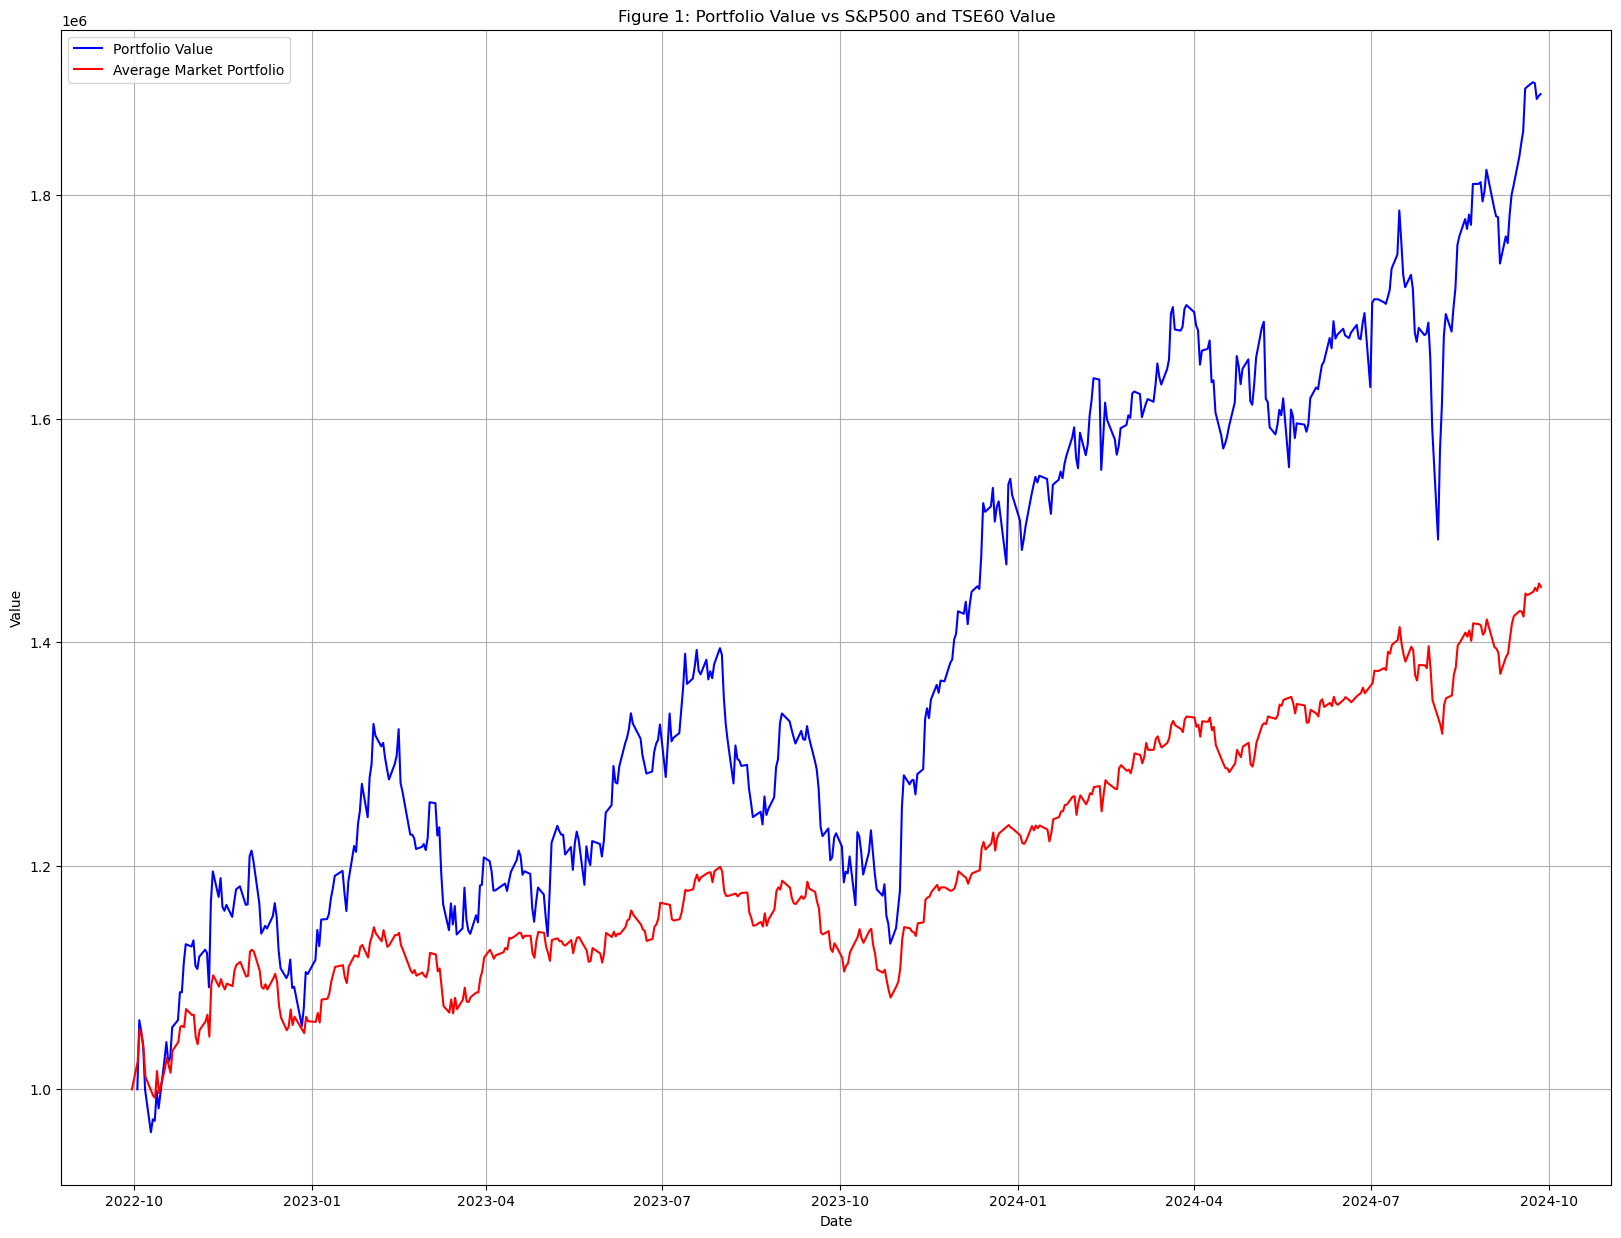

In [19]:
portfolio_value = pd.DataFrame()
market = pd.DataFrame()
final_tickers = current_best[2]
best_weights = current_best[3]
shares = []

# get number of shares
for i in range(len(final_tickers)):
    shares.append((best_weights[i]*amount)/data.iloc[0][final_tickers[i]])

# creating the optimal stocks portfolio
for i in range(len(final_tickers)):
    price = data[final_tickers[i]]
    portfolio_value[final_tickers[i]] = shares[i]*price

portfolio_value['total'] = portfolio_value.sum(axis=1)

# creating the market portfolio
snp = yf.Ticker('^GSPC').history(start=start_date, end=end_date)[['Close']].dropna()*exchange_rate
tse = yf.Ticker('^GSPTSE').history(start=start_date,end=end_date)[['Close']].dropna()*exchange_rate

snp_shares = (amount/2)/snp.iloc[0]['Close'] 
tse_shares = (amount/2)/tse.iloc[0]['Close']

market['snp'] = snp*snp_shares
market['tse'] = tse*tse_shares
market['total'] = market.sum(axis=1)

market = market.dropna()

# formatting the graph
plt.figure(figsize=(20,15))

plt.plot(portfolio_value['total'], color='b')
plt.plot(market['total'], color='r')
plt.title('Figure 1: Portfolio Value vs S&P500 and TSE60 Value')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Portfolio Value', 'Average Market Portfolio'])

plt.show()

We defined a function, sharpes_get, to calculate and analyze the Sharpe Ratios of portfolios of varying sizes, using subsets of a ranked list of stock tickers. By iterating over portfolio sizes from a minimum to a maximum number of stocks, it calculates the optimal Sharpe Ratio for each size using the optimal_sharpe function and stores the results in a DataFrame. The results are then visualized in a line plot to illustrate the relationship between portfolio size and risk-adjusted returns to show that our portfolio with {x} amount of stocks is the best compared to other sizes.

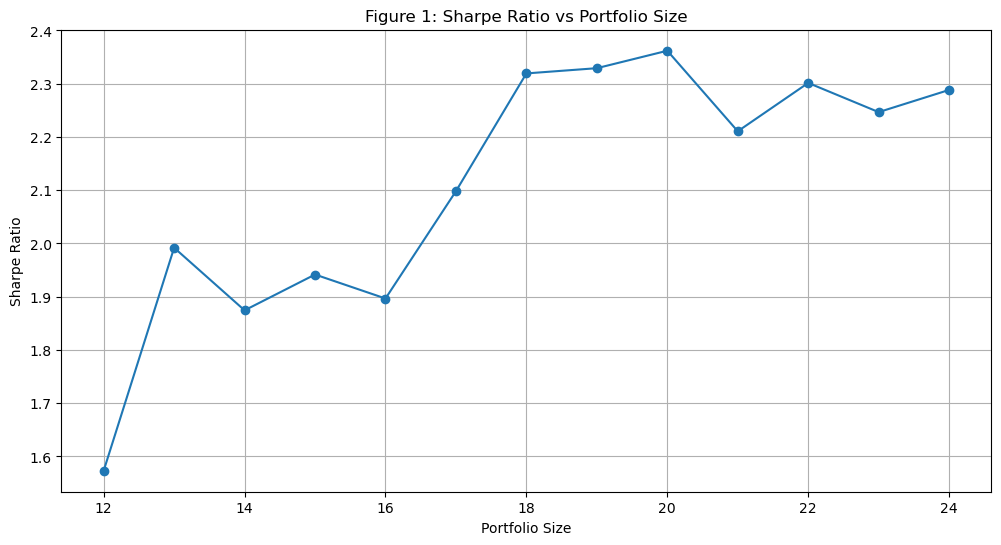

In [20]:
scored_tickers = scores.index.tolist()

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(sbdata.index, sbdata['Sharpe Ratio'], marker='o', linestyle='-')
plt.title('Figure 1: Sharpe Ratio vs Portfolio Size')
plt.xlabel('Portfolio Size')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()

We compare the Sharpe Ratio of two portfolio strategies: one optimized for maximum Sharpe Ratio using the optimal_sharpe function, and another with equal weighting across all stocks in the portfolio. The calculate_equal_weight_sharpe function computes the Sharpe Ratio for a portfolio where all stocks are assigned equal weights, considering fees and investment allocation. The results are visualized in a bar chart, comparing the Sharpe Ratio of the optimized portfolio against the equal-weighted portfolio. This helps illustrate the benefits of optimization in improving risk-adjusted returns, showing how strategic weighting can outperform simple equal allocation, as seen by the higher Sharpe Ratio.

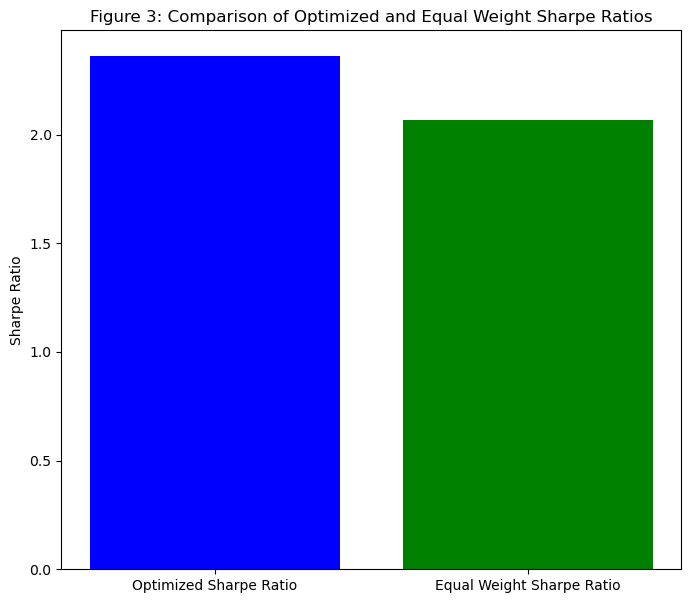

In [21]:
# Function to calculate Sharpe Ratio with equal weighting
def calculate_equal_weight_sharpe(tickers, investment, risk_free_rate=0):
    """
        Calculates the sharpe ratio of a equally weighted portfolio.
        Parameters:
            tickers (list): A yfinance DataFrame with a DatetimeIndex and stock data.
            risk_free_rate (float): The risk free rate of the market.
            investment (float): The total amount available to buy stocks.
        Returns:
            float: sharpe ratio
    """

    data = pd.DataFrame()
    for ticker in tickers:
        data[ticker] = ticker_data[ticker]

    # Number of tickers
    num_tickers = len(tickers)
    
    # Equal weights
    weights = np.array([1 / num_tickers] * num_tickers)
    
    # Determine the number of shares for each stock
    shares = []
    for i in range(num_tickers):
        allocation = investment * weights[i]  # Investment allocated to this stock
        price_per_share = data.iloc[0][tickers[i].upper()]
        
        # Calculate fees
        flat_fee = 3.95
        per_share_fee = allocation / price_per_share / (1000 + 1 / price_per_share)
        
        # Choose the smaller of the two fees
        trading_fee = min(flat_fee, per_share_fee)
        
        # Calculate the number of shares after deducting the fee
        effective_investment = allocation - trading_fee
        shares.append(effective_investment / price_per_share)
    
    # Form the portfolio
    portfolio = data[tickers] * shares
    portfolio['total'] = portfolio.sum(axis=1)
    portfolio['daily return'] = portfolio['total'].pct_change(1)
    
    # Calculate Sharpe Ratio
    er = portfolio['daily return'].mean()
    std = portfolio['daily return'].std()
    sharpe_ratio = (er - risk_free_rate) / std
    sharpe_ratio = sharpe_ratio * (252 ** 0.5)  # Annualize Sharpe Ratio

    return sharpe_ratio

# Calculate optimized Sharpe Ratio
optimized_sharpe_ratio = sbdata['Sharpe Ratio'].max()

# Calculate generic Sharpe Ratio using equal weighting
generic_sharpe_ratio = calculate_equal_weight_sharpe(scored_tickers[:sbdata['Sharpe Ratio'].idxmax()], amount, risk_free_rate=0)

# Prepare data for plotting
sharpe_data = {
    "Optimized Sharpe Ratio": optimized_sharpe_ratio,  # Get the last Sharpe Ratio (max stocks)
    "Equal Weight Sharpe Ratio": generic_sharpe_ratio
}

# Create the bar graph
plt.figure(figsize=(8, 7))
plt.bar(sharpe_data.keys(), sharpe_data.values(), color=['blue', 'green'])
plt.title("Figure 3: Comparison of Optimized and Equal Weight Sharpe Ratios")
plt.ylabel("Sharpe Ratio")
plt.show()

---
## 🏁 4. Final Output

Through the above optimizations of a ranking system, we create the following portfolio. The portfolio accounts for any necessary fees and gives a sentiment analysis through the PCR strategy and via the standard deviations of the returns we conclude a final ranking of stocks. Then we iteratively calculate the Sharpe Ratio and Beta values of the top twelve stocks all the way up to the top 24 and take the highest Sharpe Ratio while still ensuring that the Beta of the given portfolio is above one. Through this approach, we give ourselves a relatively safe portfolio that is most likely to move in an upward trend, and then by calculating and constraining the portfolio beta compared to the market, we ensure that the portfolio can generate more returns than the market. Through this strategy, the portfolio given is extremely safe and can generate returns greater than the market. It should be duly noted that the idea that a beta greater than one does not necessarily guarantee that the portfolio performs better in the positive direction, as by taking on a greater return, we simultaneously take more risk, and hence, our portfolio still has a chance to do worse than the market. However, through the sentiment analysis we hope that a general consensus of an upward trend, may result in a consensus that our portfolio will perform with an upward trend as well.  

In [22]:
# Function to create a portfolio based on the optimized Sharpe Ratio
def final_portfolio_builder():
    # Store date for November, 22, 2024 in a variable:
    date1, date2 = '2024-11-22', '2024-11-23'
    final_portfolio = current_best[2]
    final_weights = current_best[3]

    portfolio = Portfolio_Final.copy()
    portfolio.Ticker = final_portfolio

    for index, ticker in enumerate(final_portfolio):
        # Get the price of the stock on the specified date
        stock = yf.Ticker(ticker)
        currency = stock.fast_info['currency']
        stock_price = stock.history(start=date1, end=date2)['Close'].iloc[0]
        portfolio.loc[index, 'Price'] = stock_price
        # Determine the number of shares to purchase based off weight
        if currency == 'CAD':
            shares = (amount * final_weights[index]) / stock_price
            portfolio.loc[index, 'CAD Value'] = shares * stock_price
        elif currency == 'USD': 
            shares = (amount * final_weights[index]) / (stock_price * exchange_rate)
            portfolio.loc[index, 'CAD Value'] = shares * stock_price * exchange_rate
        portfolio.loc[index, 'Shares'] = shares
        # Determine the value of the stock in portfolio
        portfolio.loc[index, 'Value'] = shares * stock_price
        # Determine the weight of the stock in the portfolio
        portfolio.loc[index, 'Weight'] = final_weights[index]
        # Determine the currency of the ticker
        if ticker in stock_filter[2]:
            portfolio.loc[index, 'Currency'] = 'USD'
        else: 
            portfolio.loc[index, 'Currency'] = 'CAD'
    
    return portfolio.head(len(final_portfolio))

portfolio = final_portfolio_builder()
portfolio[['Ticker', 'CAD Value']]

,Ticker,CAD Value
0,SHOP.TO,25000.000000
1,SHOP,104176.766495
2,SQ,25000.000000
3,HOOD,25000.000000
4,DUOL,25000.000000
5,ORCL,25000.000000
6,AMZN,25000.000000
7,GOOG,25000.000000
8,IBM,25000.000000
9,AXP,25000.000000


In [23]:
Portfolio_Final = portfolio[columns]
Portfolio_Final.index = range(1, len(portfolio) + 1)

In [24]:
# Code to output final dataframe to a CSV file called Stocks_Group_XX.csv
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']]
Stocks_Final.to_csv(f'Stocks_Group_{group}.csv', index=False)

From below, we print out the total portfolio value (expected as $1,000,000) and weight of portfolio (expected as 1)

In [25]:
print(f'Total Portfolio value is {np.round(portfolio["CAD Value"].sum(), 2)}')
print(f"Weight of portfolio: {Portfolio_Final['Weight'].sum().round(3)}")

Total Portfolio value is 1000000.0
Weight of portfolio: 1.0


In [26]:
# Note: Values are in their respective currencies and do not add up to 1,000,000 CAD, see above for the summation
Portfolio_Final

,Ticker,Price,Currency,Shares,Value,Weight
1,SHOP.TO,149.479996,CAD,167.246459,25000.0,0.025
2,SHOP,106.959999,USD,696.694386,74518.430867,0.104177
3,SQ,92.260002,USD,193.829277,17882.689532,0.025
4,HOOD,36.650002,USD,487.931481,17882.689532,0.025
5,DUOL,351.970001,USD,50.807425,17882.689532,0.025
6,ORCL,192.289993,USD,92.998545,17882.689532,0.025
7,AMZN,197.119995,USD,90.719815,17882.689532,0.025
8,GOOG,166.570007,USD,107.3584,17882.689532,0.025
9,IBM,222.970001,USD,80.202222,17882.689532,0.025
10,AXP,301.299988,USD,59.351776,17882.689532,0.025


## ⌨️ Contribution Declaration

The following team members made a meaningful contribution to this assignment:

---
<p style="color: #004dd3">
Akram Jamil
</p>

<p style="color: #2C8CA9">
Jester Yang
</p>

<p style="color: #3cc19d;">
Annie Wong
</p>

---

Thank you for reading :D